In [1]:
import pandas as pd
import json
import os

files = os.listdir("results")

json_files = {}
for file in files:
    with open("results/"+file, "r") as f:
        df = pd.DataFrame(json.load(f))
        idx = file.split("_")[1][3:]
        df["idx"] = int(idx)
        json_files[file] = df

df = pd.concat(json_files.values(), axis = 0)
df

,tensor_location,criterion_score,layer_name,value_before,value_after,idx
0,"[0, 0, 593]",0.7608,class_token,-0.000760,0.000760,0
1,"[0, 0, 67]",0.7608,class_token,-0.000703,0.000703,0
2,"[0, 0, 690]",0.7608,class_token,-0.000758,0.000758,0
3,"[0, 0, 418]",0.7608,class_token,-0.000655,0.000655,0
4,"[0, 0, 583]",0.7608,class_token,-0.000602,0.000602,0
...,...,...,...,...,...,...
1515,[629],0.7608,heads.head.bias,-0.010798,-0.172764,6
1516,[64],0.7608,heads.head.bias,-0.012882,-0.206115,6
1517,[105],0.7608,heads.head.bias,-0.028462,-0.455388,6
1518,[175],0.7608,heads.head.bias,-0.051129,-0.818071,6


In [2]:
df.dtypes

tensor_location     object
criterion_score    float64
layer_name          object
value_before       float64
value_after        float64
idx                  int64
dtype: object

In [3]:
df['tensor_location'] = df['tensor_location'].astype(str).astype('|S') # which will by default set the length to the max len it encounters
df['layer_name'] = df['layer_name'].astype('|S') # which will by default set the length to the max len it encounters
df['idx'] = df['idx'].astype('|S') # which will by default set the length to the max len it encounters
df.dtypes

tensor_location       |S16
criterion_score    float64
layer_name            |S62
value_before       float64
value_after        float64
idx                   |S21
dtype: object

In [4]:
df = df.sort_values(by = ["layer_name", "idx", "tensor_location", "criterion_score"]).reset_index(drop = True)
df

,tensor_location,criterion_score,layer_name,value_before,value_after,idx
0,"b'[0, 0, 107]'",0.7608,b'class_token',0.010280,-0.010280,b'0'
1,"b'[0, 0, 123]'",0.7608,b'class_token',-0.000993,0.000993,b'0'
2,"b'[0, 0, 179]'",0.7610,b'class_token',0.003212,-0.003212,b'0'
3,"b'[0, 0, 198]'",0.7604,b'class_token',-0.015244,0.015244,b'0'
4,"b'[0, 0, 20]'",0.7608,b'class_token',-0.000803,0.000803,b'0'
...,...,...,...,...,...,...
36627,"b'[72, 427]'",0.7608,b'heads.head.weight',0.004210,0.000263,b'6'
36628,"b'[81, 527]'",0.7608,b'heads.head.weight',-0.014841,-0.237464,b'6'
36629,"b'[838, 544]'",0.7610,b'heads.head.weight',0.025741,0.411856,b'6'
36630,"b'[868, 656]'",0.7608,b'heads.head.weight',-0.003590,-0.000224,b'6'


<Axes: xlabel='idx', ylabel='criterion_score'>

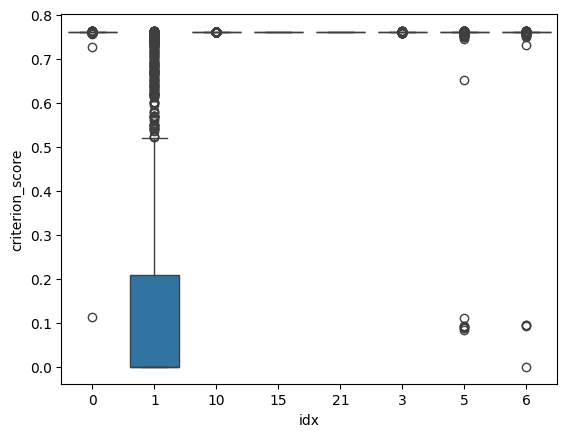

In [5]:
import seaborn as sns

sns.boxplot(data = df, x = "idx", y = "criterion_score")

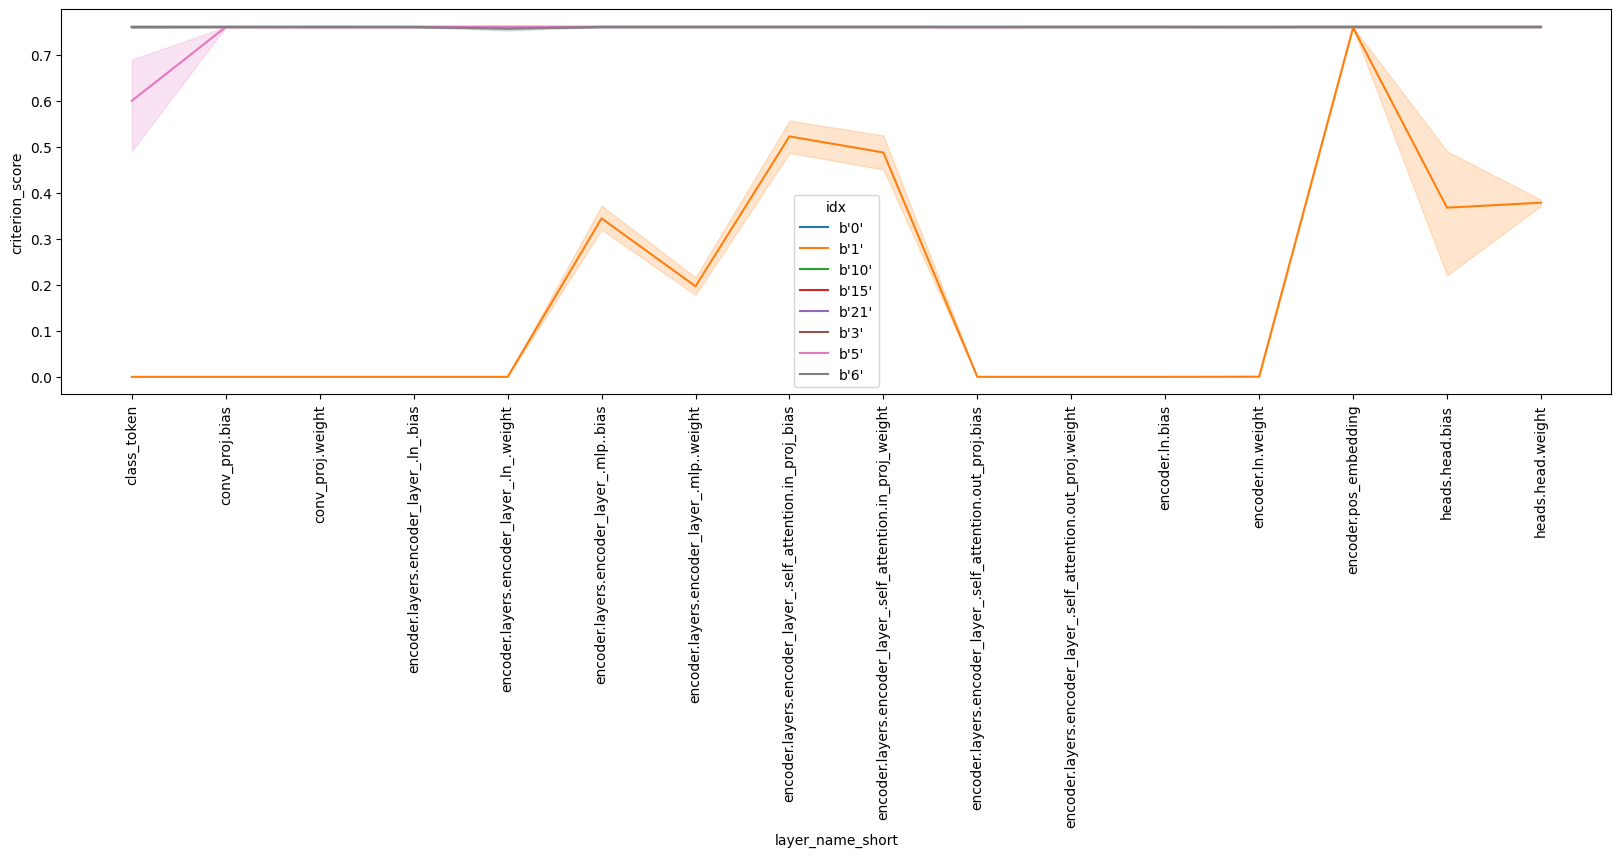

In [6]:
import matplotlib.pyplot as plt

df["layer_name_short"] = df["layer_name"].apply(lambda x: x.decode() if isinstance(x, bytes) else x).str.replace(r'\d+', '', regex=True)


plt.figure(figsize=(20,5))
sns.lineplot(data = df, x = "layer_name_short", y = "criterion_score", hue = "idx")
plt.xticks(rotation = 90)
plt.show()

In [7]:
df["idx"].value_counts()

C:\Users\wwden\AppData\Local\Temp\ipykernel_6928\2608930675.py:1: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`
  df["idx"].value_counts()


idx
b'1'     4712
b'0'     4560
b'10'    4560
b'15'    4560
b'21'    4560
b'3'     4560
b'5'     4560
b'6'     4560
Name: count, dtype: int64

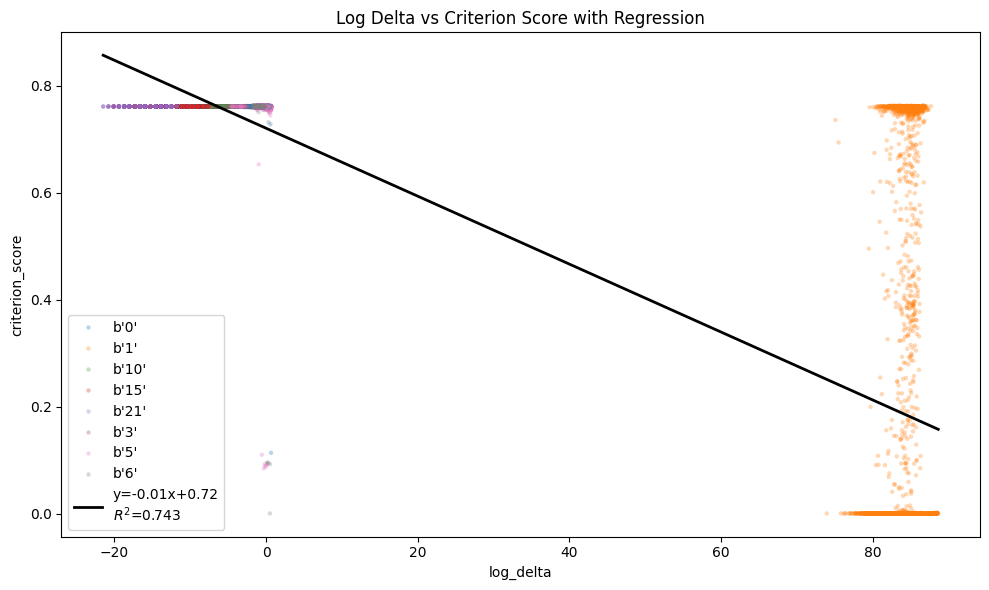

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Precompute regression
X = df["log_delta"].values.reshape(-1, 1)
y = df["criterion_score"].values
reg = LinearRegression().fit(X, y)
y_pred = reg.predict(X)
r2 = r2_score(y, y_pred)
slope = reg.coef_[0]
intercept = reg.intercept_

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="log_delta", y="criterion_score", hue="idx", alpha=0.3, s=10, linewidth=0)

# Overlay regression line
sns.lineplot(x=df["log_delta"], y=y_pred, color='black', linewidth=2, label=f"y={slope:.2f}x+{intercept:.2f}\n$R^2$={r2:.3f}")

plt.title("Log Delta vs Criterion Score with Regression")
plt.legend()
plt.tight_layout()
plt.show()


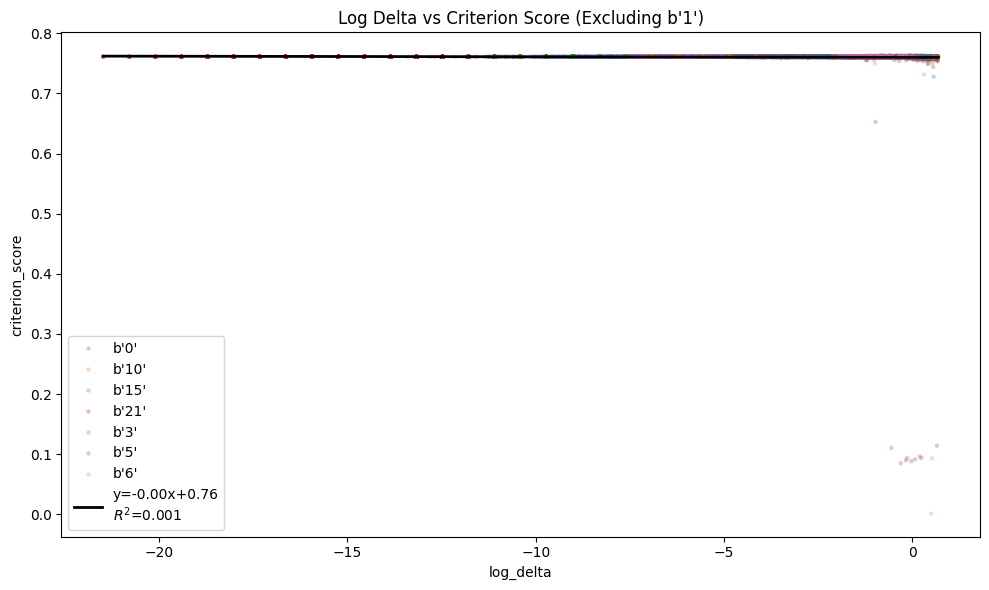

In [15]:
# Filter out b'1' from idx
df_filtered = df[df["idx"] != b'1']

# Recompute regression
X_filt = df_filtered["log_delta"].values.reshape(-1, 1)
y_filt = df_filtered["criterion_score"].values
reg_filt = LinearRegression().fit(X_filt, y_filt)
y_pred_filt = reg_filt.predict(X_filt)
r2_filt = r2_score(y_filt, y_pred_filt)
slope_filt = reg_filt.coef_[0]
intercept_filt = reg_filt.intercept_

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_filtered, x="log_delta", y="criterion_score", hue="idx", alpha=0.3, s=10, linewidth=0)

# Overlay regression line
sns.lineplot(x=df_filtered["log_delta"], y=y_pred_filt, color='black', linewidth=2,
             label=f"y={slope_filt:.2f}x+{intercept_filt:.2f}\n$R^2$={r2_filt:.3f}")

plt.title("Log Delta vs Criterion Score (Excluding b'1')")
plt.legend()
plt.tight_layout()
plt.show()
